# Minimization methods

The setup shown in @fig-3-6 was used to obtain on-axis data to reconstruct base functions at different off-axis position. The methodology for this is described in @fig-4-1 :

![Methodology to acquire a base function](figures/c/fig_4_1_minimization.png){#fig-4-1}

1. **Starting base function:** The reconstructed base function from @fig-3-5 was used as a starting function even if the sampling points were not perfectly aligned with their corresponding angles.

2. **Starting optosurf axis:** These are the 32 pixels that go from -15 to 15 deg with 1 deg steps.

3. **On-axis dataset:** An on-axis dataset of very Si smooth wafers (0.1 nm roughness). The mechanical axis was acquired within an angle range with a certain numbers of slices, for example +-20 deg (equivalent to 40 deg due to reflection angle) with 4096 slices. Each slice has a 32 sampling points optosurf trace.

**Minimization function:** 

4. **Iteration over the slices of the on-axis dataset:** Each slice of the on-axis dataset is iterated and is used as the reference experimental data to be fit.

5. **Applying cost/minimization function:** This function takes the experimental data and makes a fit using three parameters:
- x0 - Equivalent to a lateral displacement of the base function.
- A0 - A factor multiplying the amplitude of the base function.
- pchip interpolator - A pchip (Piecewise Cubic Hermite Interpolating Polynomial) interpolator is an algorithm used to smooth the base function to a 32 points xaxis (starting optosurf axis + x0).


6. **Output variables:** The output variables of the minimization function are:
* The mechanical angle (corresponding to the mechanical scanning)
* x0 - Equivalent to a lateral displacement of the base function. Notice that x0 = 0 is the reference to know where the light is normally incident to the optosurf head. 
* A0 - A factor multiplying the amplitude of the base function.
* RMSE - The optimization error measurement

**Displacement correction**

7. **Find x0 = 0 (normal incident plane)**

8. **Find the mechanical angle corresponding to x0 = 0:** This defines a displacement correction angle for the mechanical axis such that zero degrees correspond to the x0 of the optosurf axis.

## Datasets
The acquired on-axis and off-axis datasets are shown in @fig-4-2 :

![On-axis datasets. Notice that as the roughness increases the amplitude decreases as well as becoming broader](figures/c/fig_4_2_datasets.png){#fig-4-2}

These datasets were acquired along the on-axis within an angle of 20 deg (40 deg due to double reflection angle) and at 6 different off-axis positions from -0.150 to 0.150 deg in 0.05 deg steps. Notice how for much smoother wafers (0.1 nm) the signal amplitude is much higher (around 35,000 in amplitude). As the sample becomes rougher the amplitude decreases and the signal becomes wider as well. This is illustrated in the Ann 1 min - Ann 5 min. The time represents the polish time, as the sample becomes smoother with higher polishing time the amplitude increases. 

The parameters for each dataset are shown in @tbl-1. The datasets with a roughness of 0.1 nm are used as the reference to reconstruct the base function. The RMSE is then calculated with respect to these base functions for rougher wafers.

In [4]:
#| label: tbl-1
#| tbl-cap: On-axis and off-axis datasets parameters
import pandas as pd
df_datasets_temp = pd.read_csv("../data/c_datasets_table.csv").set_index('wafer')

# df_datasets_temp = df_datasets.drop(['plot', 'baser', 'slice1guess', 'slice2guess', 'slice1', 'slice2', 'location',
#                                      'min_df', 'shifted', 'base', 'dataset', 'normal_slice', 'sliceonedeg'], axis=1)
# df_datasets_temp = df_datasets_temp.rename(columns={'points': 'slices'})
display(df_datasets_temp)

,roughness (nm),points,angle
wafer,,,
W1_0.11nm,0.11,4096,20
W2_0.13nm,0.13,4096,20
W3_0.1 nm,0.10,4096,20
W4_1nm,1.00,4096,20
W5_0.97nm,0.97,4096,20
W6,NaN,4096,20
W7_315nm,315.00,4096,20
W8_5min,NaN,4096,20
W8_4min,NaN,4096,20


In [5]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
import math
import seaborn as sns

my_theme = {
    "figure.facecolor": "white", 
    "axes.facecolor": "white", # green
    "axes.edgecolor": "white",
    "axes.labelcolor": "#4E616A",
    "axes.grid": True,
    "grid.color": "#E0E0E0",
    "xtick.color": "black",
    "ytick.color": "black",
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "Tahoma"]
}

def plot_format_plt(xlabel, ylabel, xticks, yticks, ax):
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.xaxis.set_major_locator(plt.MultipleLocator(xticks))  # Set x-axis tick frequency
    ax.yaxis.set_major_locator(plt.MultipleLocator(yticks))


# 1. Define cost function
def cost_function(params, y, x, chip):
    """
    Generates a 3D plot of the data

    Parameters
    ----------
    params (list): List of parameters to fit
    y (array): Array with the data to fit
    
    Returns
    -------
    rmse (float): Root mean square error of the fit0.
    """
    x0, A0 = params
    x_new = x + x0
    y_modified = A0*chip(x_new)

    mse = np.mean((y - y_modified) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def slice_optimization(slices, onaxis, offaxis, dataset, pchip):
    minimized_df = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])
    for j, slice in enumerate(slices):
        # 1. Get initial guess
        x0 = offaxis[slice]
        Abase = 1.0
        guess_no_back = [x0, Abase]

        # 2. Call minimization function
        y = dataset[:,slice]
        cost_fn = lambda p:cost_function(p, y, onaxis, pchip)
        result = minimize(cost_fn, guess_no_back, method=method,)
        optimized_parameters = list(result.x)
        x0_opt, A0_opt, = optimized_parameters
        x_new_opt = onaxis + (x0_opt)
        y_optimized = A0_opt*pchip(x_new_opt)
        
        # 10. Calculate error
        mse = np.mean((y - y_optimized) ** 2)
        rmse = np.sqrt(mse)
        row = [offaxis[slice], x0_opt, offaxis[slice] - x0_opt, slice, A0_opt, rmse]
        minimized_df.loc[j] = row
    return minimized_df

# 2. Get initial base function
smooth_df = pd.read_csv("../data/b_starting_base.csv")
x_base = smooth_df['xaxis']
y_base = smooth_df['yaxis']
pchip = PchipInterpolator(x_base, y_base)
method = 'Powell'

# 3. Get datasets df
# path_datasets = '../data/c_datasets.csv'
path_datasets = '../data/c_datasetsa.csv'
df_datasets = pd.read_csv(path_datasets).set_index('file')
df_datasets['min_df'] = None
df_datasets['dataset'] = None
df_datasets['shifted'] = None
df_datasets['base'] = None
df_datasets = df_datasets[(df_datasets['plot'] == 'x') | (df_datasets['baser'] == 'x')]
# df_datasets = df_datasets.sort_values(by=['baser'])

# # 5. Create 3D subplot
# rows = 5
# cols = 3

# # fig, axes = plt.subplots(rows, cols, figsize=(18, 25), squeeze=False, gridspec_kw={'hspace': 0.5})
# x = np.linspace(0, 10, 100)
# z = np.linspace(0, 10, 100)
# y = np.linspace(-15.5, 15.5, 100)
# X, Z = np.meshgrid(x, z)
# Y, Z2 = np.meshgrid(y, z)
onaxis=np.arange(-15.5,16.5,1)
# plot_count = 0

for file, row in df_datasets.iterrows():
    # 6. Get slices and offaxis for each dataset
    slices = np.arange(row.slice1guess, row.slice2guess, step=1)
    offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points
    offaxis_slices = np.arange(0, row.points, 1)
    dataset_path = row.location + file
    dataset = np.genfromtxt(dataset_path, delimiter=',')
    minimized_df = slice_optimization(slices, onaxis, offaxis, dataset, pchip)

    # 7. Get normal slice
    if 'offaxis' not in file:
        normal_slice = minimized_df.loc[minimized_df['x0'] < 0.0]['slice'].iloc[-1]+1
        normal_slice = int(normal_slice)
        scanning_step = offaxis[1] - offaxis[0]
        slices_one_deg = math.ceil(1.0/scanning_step)
        slice_1_correct = normal_slice - slices_one_deg//2
        slice_2_correct = normal_slice + slices_one_deg//2
        displacement = float(minimized_df.loc[minimized_df['slice'] == normal_slice]['angle'])
        
    else: 
        max = np.max(dataset)
        max_idx = np.where(dataset == max)
        normal_slice = max_idx[1][0]
        scanning_step = offaxis[1] - offaxis[0]
        slices_one_deg = math.ceil(1.0/scanning_step)
        slice_1_correct = normal_slice - slices_one_deg//2
        slice_2_correct = normal_slice + slices_one_deg//2
        displacement = offaxis[normal_slice]

    minimized_df['angle'] = minimized_df['angle'] - displacement
    minimized_df['difference'] = minimized_df['difference'] - displacement

    # 8. Update datasets df
    df_datasets.loc[file, 'normal_slice'] = normal_slice
    df_datasets.loc[file, 'slice1'] = slice_1_correct
    df_datasets.loc[file, 'slice2'] = slice_2_correct
    df_datasets.loc[file, 'sliceonedeg'] = slices_one_deg
    df_datasets.loc[file, 'displacement'] = displacement
    df_datasets.at[file, 'min_df'] = minimized_df
    df_datasets.at[file, 'dataset'] = dataset
    
# #     # 9. Plot 3D surface
#     # off_axis_angles = offaxis - displacement

# #     row_plot = plot_count // cols
# #     col_plot = plot_count % cols

# #     # ax = axes[row_plot][col_plot]
# #     # ax = fig.add_subplot(rows, cols, row_plot*cols+col_plot+1, projection='3d')
    
# #     # X, Y = np.meshgrid(off_axis_angles, onaxis)
# #     # ax.plot_surface(X, Y, dataset, cmap='jet')
# #     # ax.set_title(file)
# #     # ax.set_ylabel('OS axis', fontweight='bold')
# #     # ax.set_xlabel('Mechanical axis', fontweight='bold')
# #     # ax.set_box_aspect([1.5, 1, 1.0])
# #     # plot_count+=1

# # # sns.set_style("white", rc=my_theme)
# # # fig.tight_layout()
# df_datasets.to_pickle('../data/c_datasets.pickle')

In [6]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
import math
import seaborn as sns

my_theme = {
    "figure.facecolor": "white", 
    "axes.facecolor": "white", # green
    "axes.edgecolor": "white",
    "axes.labelcolor": "#4E616A",
    "axes.grid": True,
    "grid.color": "#E0E0E0",
    "xtick.color": "black",
    "ytick.color": "black",
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "Tahoma"]
}

def plot_format_plt(xlabel, ylabel, xticks, yticks, ax):
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.xaxis.set_major_locator(plt.MultipleLocator(xticks))  # Set x-axis tick frequency
    ax.yaxis.set_major_locator(plt.MultipleLocator(yticks))


# 1. Define cost function
def cost_function(params, y, x, chip):
    """
    Generates a 3D plot of the data

    Parameters
    ----------
    params (list): List of parameters to fit
    y (array): Array with the data to fit
    
    Returns
    -------
    rmse (float): Root mean square error of the fit0.
    """
    x0, A0 = params
    x_new = x + x0
    y_modified = A0*chip(x_new)

    mse = np.mean((y - y_modified) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def slice_optimization(slices, onaxis, offaxis, dataset, pchip):
    minimized_df = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])
    for j, slice in enumerate(slices):
        # 1. Get initial guess
        x0 = offaxis[slice]
        Abase = 1.0
        guess_no_back = [x0, Abase]

        # 2. Call minimization function
        y = dataset[:,slice]
        cost_fn = lambda p:cost_function(p, y, onaxis, pchip)
        result = minimize(cost_fn, guess_no_back, method=method,)
        optimized_parameters = list(result.x)
        x0_opt, A0_opt, = optimized_parameters
        x_new_opt = onaxis + (x0_opt)
        y_optimized = A0_opt*pchip(x_new_opt)
        
        # 10. Calculate error
        mse = np.mean((y - y_optimized) ** 2)
        rmse = np.sqrt(mse)
        row = [offaxis[slice], x0_opt, offaxis[slice] - x0_opt, slice, A0_opt, rmse]
        minimized_df.loc[j] = row
    return minimized_df

# 2. Get initial base function
smooth_df = pd.read_csv("../data/b_starting_base.csv")
x_base = smooth_df['xaxis']
y_base = smooth_df['yaxis']
pchip = PchipInterpolator(x_base, y_base)
method = 'Powell'

onaxis=np.arange(-15.5,16.5,1)
# df_datasets = pd.read_pickle('../data/c_datasetsa.pickle')

## Minimization 1st iteration
Once the datasets have been acquired the 1st step is to apply the minimization function (steps 4 and 5) of @fig-4-1 for each of the 4096 slices of the dataset. The output of the minimization function is the mechanical angle, x0, A0 and RMSE. The normal incidence is defined at x0 = 0, with this a displacement correction factor is calculated for the mechanical axis (step 7 and 8 of @fig-4-1). 

The output of the minimization function for the wafers used a base function (0.1 nm roughness) is shown in @fig-4-3 :

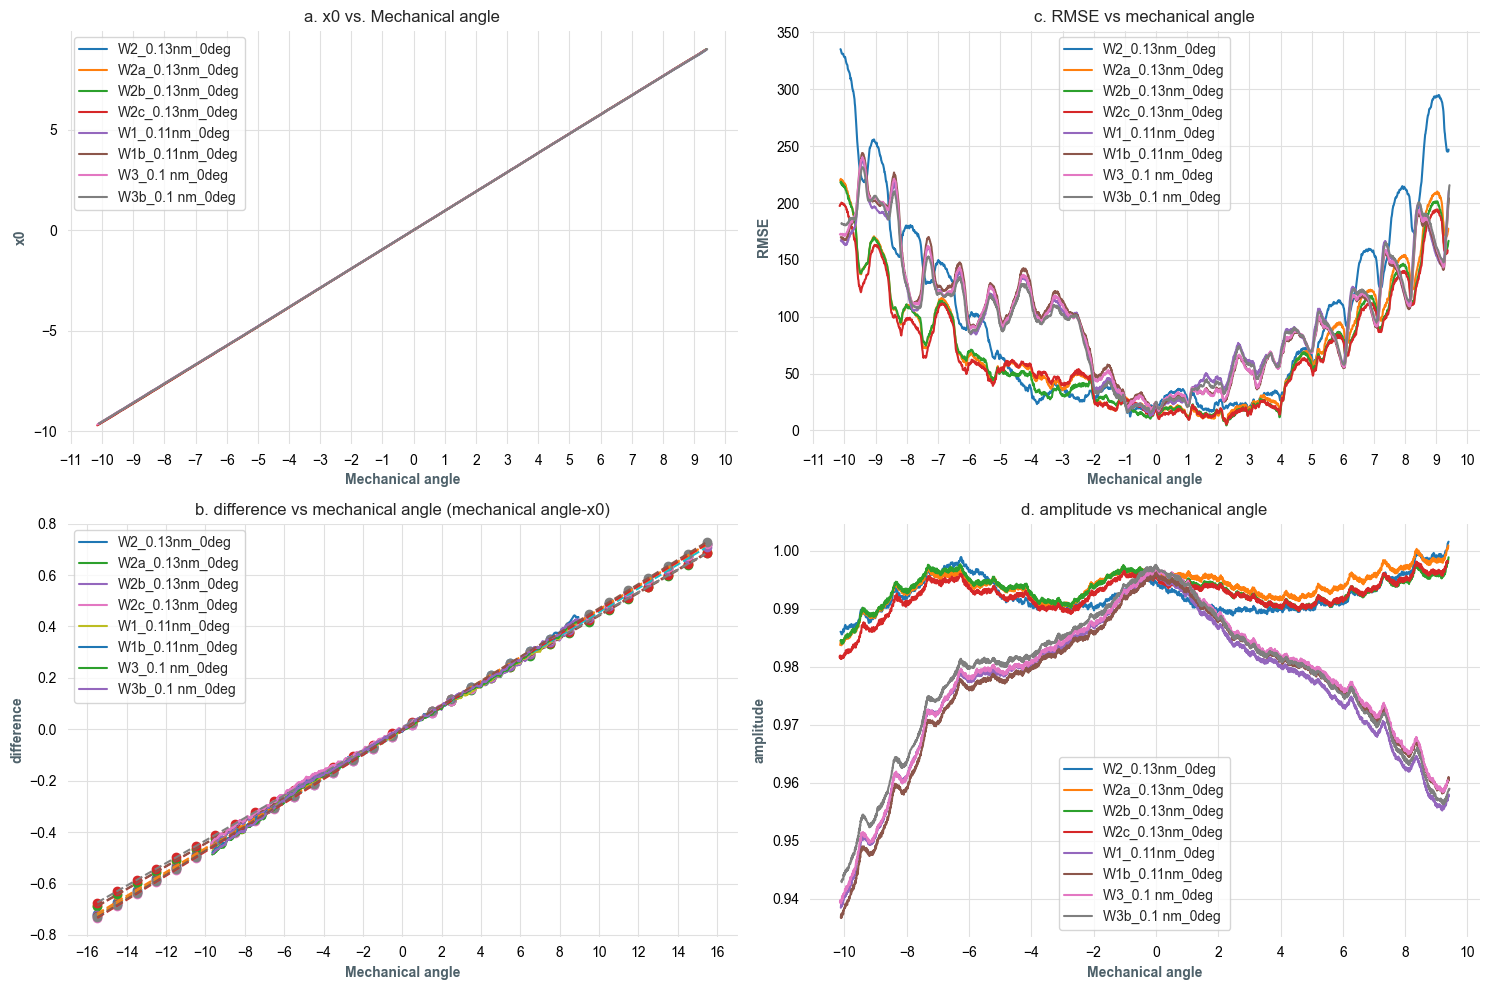

In [8]:
#| label: fig-4-3
#| fig-cap: "1st optimization iteration for 0.1 nm Si wafers"

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

fig_1st, axes_1st = plt.subplots(2, 2, figsize=(15, 10), squeeze=False)
plot_count = 0

for file, row in df_datasets[(df_datasets['baser'] == 'x') & (df_datasets['offaxisvalue'] == 0)].iterrows():
    # slices_filter = (minimized_df['slice'] >= row.slice1) & (minimized_df['slice'] <= row.slice2)
    # minimized_df = minimized_df.loc[slices_filter]
    minimized_df = row.min_df.copy()
    angles = minimized_df['angle'].values
    x0 = minimized_df['x0'].values
    differences = minimized_df['difference'].values
    amplitudes = minimized_df['amplitude'].values
    rmse = minimized_df['rmse'].values
    label = row.label
    
    # 1. Rotation angle vs. x0
    axes_1st[0][0].plot(angles, x0, label=label)

    # 2. Rotation angle vs RMSE
    axes_1st[0][1].plot(angles, rmse, label=label)

    # 3. Polynomial fit of x0 vs difference
    poly = PolynomialFeatures(degree=1)
    x0_poly = poly.fit_transform(x0.reshape(-1,1))
    poly_model = LinearRegression().fit(X=x0_poly, y=differences)
    xaxis = np.arange(-15.5, 15.5, 0.1)
    xaxis_poly = poly.transform(xaxis.reshape(-1,1))
    ypoly = poly_model.predict(xaxis_poly)
    axes_1st[1][0].plot(x0, differences, label=label)
    axes_1st[1][0].plot(xaxis, ypoly, linestyle='--')

    # 4. Calculate shifted axis
    onaxis_poly = poly.transform(onaxis.reshape(-1,1))
    y_shifted = poly_model.predict(onaxis_poly)
    axes_1st[1][0].scatter(onaxis, y_shifted)
    shifted_axis = onaxis + y_shifted
    df_datasets.at[file, 'shifted'] = shifted_axis

    # 5. Rotation angle vs amplitude with interpolation
    axes_1st[1][1].plot(angles, amplitudes, label=label)
    
    
axes_1st[0][0].legend()
axes_1st[0][0].set_title('a. x0 vs. Mechanical angle')
plot_format_plt('Mechanical angle', 'x0', 1, 5, axes_1st[0, 0])

axes_1st[0][1].legend()
axes_1st[0][1].set_title('c. RMSE vs mechanical angle')
plot_format_plt('Mechanical angle', 'RMSE', 1, 50, axes_1st[0, 1])

axes_1st[1][0].legend()
axes_1st[1][0].set_title('b. difference vs mechanical angle (mechanical angle-x0)')
plot_format_plt('Mechanical angle', 'difference', 2, 0.2, axes_1st[1, 0])

axes_1st[1][1].legend()
axes_1st[1][1].set_title('d. amplitude vs mechanical angle')
plot_format_plt('Mechanical angle', 'amplitude', 2, 0.01, axes_1st[1, 1])

sns.set_style("white", rc=my_theme)
fig_1st.tight_layout()

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

for file, row in df_datasets[(df_datasets['baser'] == 'x')].iterrows():
    # slices_filter = (minimized_df['slice'] >= row.slice1) & (minimized_df['slice'] <= row.slice2)
    # minimized_df = minimized_df.loc[slices_filter]
    minimized_df = row.min_df.copy()
    angles = minimized_df['angle'].values
    x0 = minimized_df['x0'].values
    differences = minimized_df['difference'].values
    amplitudes = minimized_df['amplitude'].values
    rmse = minimized_df['rmse'].values
    label = row.label

    # 3. Polynomial fit of x0 vs difference
    poly = PolynomialFeatures(degree=1)
    x0_poly = poly.fit_transform(x0.reshape(-1,1))
    poly_model = LinearRegression().fit(X=x0_poly, y=differences)
    xaxis = np.arange(-15.5, 15.5, 0.1)
    xaxis_poly = poly.transform(xaxis.reshape(-1,1))
    ypoly = poly_model.predict(xaxis_poly)
   
    # 4. Calculate shifted axis
    onaxis_poly = poly.transform(onaxis.reshape(-1,1))
    y_shifted = poly_model.predict(onaxis_poly)
    axes_1st[1][0].scatter(onaxis, y_shifted)
    shifted_axis = onaxis + y_shifted
    df_datasets.at[file, 'shifted'] = shifted_axis    

The meaning of the plots is:

a. x0 vs mechanical angle. The mechanical angle is the known scanning angle position from the scanning along the on-axis. x0 is the fit parameter of the minimization function. Notice that x0 = 0 is the reference to know where the light is normally incident to the optosurf head. If they both cross at 0,0 then the mechanical axis is aligned with the optosurf axis. If they don't cross at 0,0 then there is a displacement between the mechanical axis and the optosurf axis. This displacement is corrected by applying a correction factor to the mechanical axis.

b. difference vs mechanical angle (mechanical angle-x0). This is the plot of difference between the mechanical angle and the x0. Ideally, after more optimization iterations the difference will converge to zero. With this difference a new optosurf axis is calculated.

c. RMSE vs mechanical angle. This plot is the RMSE per slice calculated from the minimization function. Ideally, after more optimization iterations the RMSE will converge to zero.

d. amplitude vs mechanical angle. This is the amplitude correction factor calculated from the minimization function. 

The optosurf shifted axis for the 1st iteration is shown in @fig-4-4 :

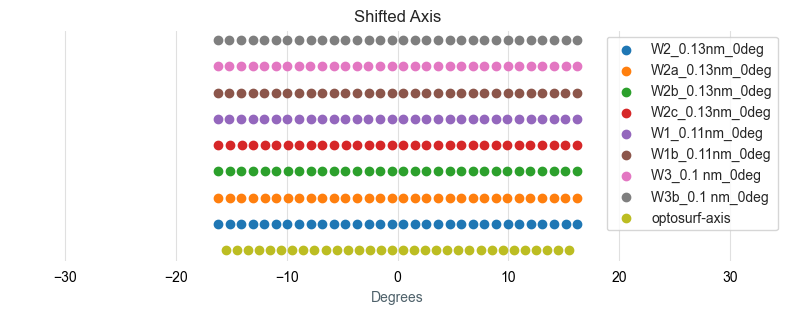

In [10]:
#| echo: false
#| label: fig-4-4
#| fig-cap: "Optosurf shifted axis"

plt.figure(figsize=(10, 3))
count = 0 
for file, row in df_datasets[(df_datasets['baser'] == 'x') & (df_datasets['offaxisvalue'] == 0)].iterrows():
    label = row.label
    plt.scatter(row.shifted, 0.5*count*np.ones(32),label=label)
    count+=1
plt.scatter(onaxis, -0.5*np.ones(32),label='optosurf-axis')
plt.legend()
plt.xlim(-35, 35)  # add x_range
plt.title('Shifted Axis');  # add title
plt.ylabel('')  # remove y-axis label
plt.xlabel('Degrees')  # add x-axis label
plt.yticks([]);

## Base function 1st iteration

Once the minimization parameters have been calculated (x0, A0) a new shifted axis was calculated. The process to reconstruct the base function is to take the slices from the on-axis dataset that cover a one degree range. The data is then plot with respect to the new shifted axis and recentered with respect to the known mechanical angle.

With this a highest density of sampling point is obtained for the base function. An average is then calculated and finally an interpolation is done. Examples of base functions are shown in @fig-4-5 :

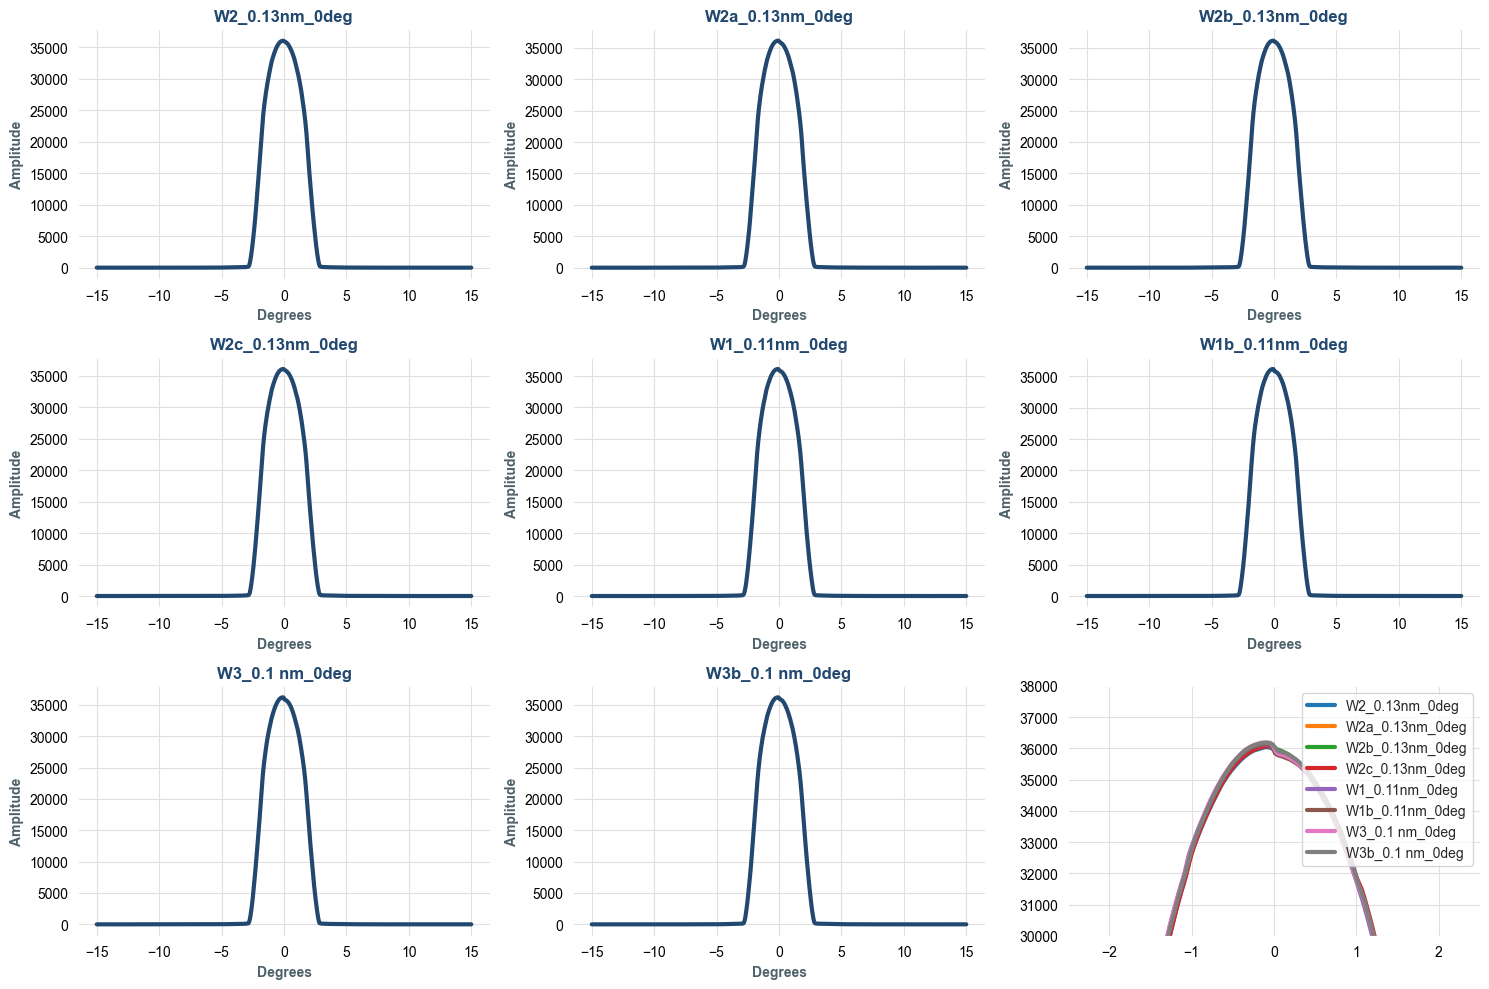

In [11]:
#| label: fig-4-5
#| fig-cap: "Base functions for 0.1 nm Si wafers"

def average_base(base_function, window_size):
    x_filtered = base_function['xaxis'].values
    y_filtered = base_function['yaxis'].values
    x_averaged = []
    y_averaged = []
    for i in np.arange(np.min(x_filtered), np.max(x_filtered), window_size):
        # get the indices of the points within the current window
        indices = np.where((x_filtered >= i) & (x_filtered < i + window_size))[0]
        if len(indices) == 0:
            continue
        # calculate the average x and y values for the points in the current window
        x_avg = np.mean(x_filtered[indices])
        y_avg = np.mean(y_filtered[indices])
        x_averaged.append(x_avg)
        y_averaged.append(y_avg)
    return x_averaged, y_averaged

rows = 3
cols = 3
window_size = 0.05

fig_base, axes_base = plt.subplots(rows, cols, figsize=(15, 10), squeeze=False)
plot_count = 0

for file, row in df_datasets[(df_datasets['baser'] == 'x') & (df_datasets['offaxisvalue'] == 0)].iterrows():
    # 1. Get datasets and minimization values
    dataset = row.dataset
    minimized_df = row.min_df.copy()
    slices_filter = (minimized_df['slice'] >= row.slice1) & (minimized_df['slice'] <= row.slice2)
    minimized_df = minimized_df.loc[slices_filter].set_index('slice')
    slices_base = np.arange(row.slice1, row.slice2+1, 1)

    # 2. Get shifted axis and define empty x_base and y_base arrays
    shifted_axis = row.shifted
    x_base_array = []
    y_base_array = []
    slice_array = []

    # 3. Iterate through slices
    for k, slice in enumerate(slices_base):
        # 4. Get individual slice with 32 points and its corresponding correction factors
        y_temp = dataset[:,slice]
        angle = minimized_df.loc[slice, 'angle']
    
        # 5. Reshift back to center
        new_shifted_axis = shifted_axis + angle
        x_base_array.extend(list(new_shifted_axis))
        y_base_array.extend(list(y_temp))
        slice_array.extend(np.ones(len(new_shifted_axis))*slice)

    # 4. Create df with base function
    base_function_df = pd.DataFrame({'xaxis': x_base_array, 'yaxis': y_base_array, 'slice': slice_array})
    base_function_df = base_function_df.sort_values(by='xaxis')

    # 5. Merge base function with minimized df
    base_function_merged = base_function_df.merge(minimized_df, on=['slice', 'slice'])

    # 6. Calculate average base function
    x_averaged, y_averaged = average_base(base_function_merged, window_size)
    pchip_base = PchipInterpolator(x_averaged, y_averaged)
    x_base_interp = np.linspace(-15, 15, 1000)
    y_base_interp = pchip_base(x_base_interp)

    # 7. Plot base function
    row_plot = plot_count // cols
    col_plot = plot_count % cols

    axes_base[row_plot, col_plot].set_title(row.label, color = '#224870', fontweight='bold')
    axes_base[row_plot, col_plot].plot(x_base_interp, y_base_interp, color='#224870', linewidth=3)

    plot_format_plt('Degrees', 'Amplitude', 5, 5000, axes_base[row_plot, col_plot])
    axes_base[2, 2].plot(x_base_interp, y_base_interp, label=row.label, linewidth=3)
    plot_count+=1

    # 9. Save base function
    df_datasets.at[file, 'base'] = base_function_merged

axes_base[2, 2].legend()
axes_base[2, 2].set_xlim(-2.5,2.5)
axes_base[2, 2].set_ylim(30000,38000)

# xlim(-35, 35)  # add x_range
sns.set_style("white", rc=my_theme)
fig_base.tight_layout()
plt.show()

In [12]:
window_size = 0.05
for file, row in df_datasets[(df_datasets['baser'] == 'x')].iterrows():
    # 1. Get datasets and minimization values
    dataset = row.dataset
    minimized_df = row.min_df.copy()
    slices_filter = (minimized_df['slice'] >= row.slice1) & (minimized_df['slice'] <= row.slice2)
    minimized_df = minimized_df.loc[slices_filter].set_index('slice')
    slices_base = np.arange(row.slice1, row.slice2+1, 1)

     # 2. Get shifted axis and define empty x_base and y_base arrays
    shifted_axis = row.shifted
    x_base_array = []
    y_base_array = []
    slice_array = []

    # 3. Iterate through slices
    for k, slice in enumerate(slices_base):
        # 4. Get individual slice with 32 points and its corresponding correction factors
        y_temp = dataset[:,slice]
        angle = minimized_df.loc[slice, 'angle']
    
        # 5. Reshift back to center
        new_shifted_axis = shifted_axis + angle
        x_base_array.extend(list(new_shifted_axis))
        y_base_array.extend(list(y_temp))
        slice_array.extend(np.ones(len(new_shifted_axis))*slice)

    # 4. Create df with base function
    base_function_df = pd.DataFrame({'xaxis': x_base_array, 'yaxis': y_base_array, 'slice': slice_array})
    base_function_df = base_function_df.sort_values(by='xaxis')

    # 5. Merge base function with minimized df
    base_function_merged = base_function_df.merge(minimized_df, on=['slice', 'slice'])

    # 6. Calculate average base function
    x_averaged, y_averaged = average_base(base_function_merged, window_size)
    pchip_base = PchipInterpolator(x_averaged, y_averaged)
    x_base_interp = np.linspace(-15, 15, 1000)
    y_base_interp = pchip_base(x_base_interp)

    # 9. Save base function
    df_datasets.at[file, 'base'] = base_function_merged

## RMSE optimization

Once the 1st iteration has been completed there are several parameters that have been calculated:

1. x0 - equivalent to the correction factor for the mechanical axis.
2. A0 - equivalent to the amplitude correction factor.
3. RMSE - the error of the minimization function.
4. Base function - the reconstructed base function.

All of these variables are taken and the procedure shown in @fig-4-1 is re-iterated until the x0 and the mechanical axis have a zero difference between each other. This will reduce the RMSE per iteration. The final RMSE which is to be used as the error base function for roughness characterization is shown in @fig-4-6 :

In [13]:
def cost_function_a(params, y, x, chip):
    """
    Generates a 3D plot of the data

    Parameters
    ----------
    params (list): List of parameters to fit
    y (array): Array with the data to fit
    
    Returns
    -------
    rmse (float): Root mean square error of the fit0.
    """
    x0, A0 = params
    x_new = x + x0
    y_modified = A0*chip(x_new)
    mse = np.mean((y - y_modified) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def minimize_procedure(slices_list, starting_minimized, x, chip, values, offaxis):
    """
    Minimizes the cost function for each slice from the 3D dataset

    Parameters
    ----------
    slices (list): List of slices to optimize
    starting_minimized (DataFrame): DataFrame with initial guesses for the parameters

    Returns
    -------
    dfc (DataFrame): DataFrame with the optimized parameters and RMSE for each slice.
    """
    dfc = pd.DataFrame(columns=["angle", "x0", "difference", "slice", "amplitude", "rmse"])
    for j, sliceb in enumerate(slices_list):
        # Get initial guesses from previous df
        x0 = starting_minimized.loc[sliceb]['x0']
        angle = starting_minimized.loc[sliceb]['angle']
        Abase = starting_minimized.loc[sliceb]['amplitude']
        guess = [angle, Abase]

        # Call minimize function
        ya = values[:, sliceb]
        cost_fn = lambda p:cost_function_a(p, ya, x, chip)
        result = minimize(cost_fn, guess, method=method)
        optimized_parameters = list(result.x)
        x0_opt, A0_opt, = optimized_parameters
        
        # Calculate optimized function
        x_new_opt = x + (x0_opt)
        y_optimized = A0_opt*chip(x_new_opt) 

        # Calculate error
        mse = np.mean((ya - y_optimized) ** 2)
        rmse = np.sqrt(mse)
        row = [offaxis[sliceb], x0_opt, offaxis[sliceb] - x0_opt, sliceb, A0_opt, rmse]
        dfc.loc[j] = row
    return dfc


left = 0
right = 0
color = 0

for file, row in df_datasets[(df_datasets['baser'] == 'x')].iterrows():
    # 1. Define starting values (base/axis/min_df)
    starting_base = row.base.copy()
    starting_axis = row.shifted.copy()
    starting_minimized = row.min_df.copy()
    slices_filter = (starting_minimized['slice'] >= (row.slice1-left)) & (starting_minimized['slice'] <= (row.slice2+right))
    starting_minimized = starting_minimized.loc[slices_filter].set_index('slice')
    slices_base = np.arange(row.slice1, row.slice2, 1)
    experimental_data = row.dataset
    offaxis = np.arange(-row.points//2, row.points//2, 1)*(2*row.angle)/row.points - row.displacement

    for u in range(1,5):
        # 7. Calculate the p chip with the starting base function
        x_averaged, y_averaged = average_base(starting_base, window_size)
        pchip_base = PchipInterpolator(x_averaged, y_averaged)

        # 8. Call the minimization procedure with the starting minimized_df and shifted axis
        min_df = minimize_procedure(slices_base, starting_minimized, starting_axis, pchip_base, experimental_data, offaxis)

        # 9. x0 vs difference polynomial fit
        poly = PolynomialFeatures(degree=1)
        x0 = min_df['angle'].values
        difference = min_df['difference'].values
        x0_poly = poly.fit_transform(x0.reshape(-1,1))
        model = LinearRegression().fit(X=x0_poly, y=difference)
        xaxis = np.arange(-15.5, 15.5, 0.1)
        xaxis_poly = poly.transform(xaxis.reshape(-1,1))
        ypredictions = model.predict(xaxis_poly)

        # 10. Calculate shifted axis
        onaxis_poly_temp = poly.transform(starting_axis.reshape(-1,1))
        y_shifted_temp = model.predict(onaxis_poly_temp)
        shifted_axis_temp = starting_axis + y_shifted_temp

        # 11. Calculate new base function
        x_base_array = []
        y_base_array = []
        slice_array = []
        min_df = min_df.set_index('slice')
        for k, slice in enumerate(slices_base):
            # Get individual slice with 32 points and its corresponding correction factors
            y_temp = experimental_data[:, slice]
            angle = min_df.loc[slice, 'angle']

            # 3. Reshift back to center
            new_shifted_axis = shifted_axis_temp + angle
            x_base_array.extend(list(new_shifted_axis))
            y_base_array.extend(list(y_temp))
            slice_array.extend(np.ones(len(new_shifted_axis))*slice)

        # Create df with base function
        base_function_df = pd.DataFrame({'xaxis': x_base_array, 'yaxis': y_base_array, 'slice': slice_array})
        base_function_df = base_function_df.sort_values(by='xaxis')

        # Merge base function with minimized df
        base_function_merged = base_function_df.merge(min_df, on=['slice', 'slice'])
        
        # 13. Update the starting axis and minimized_df
        starting_axis = shifted_axis_temp
        starting_minimized = min_df.copy()
        starting_base = base_function_merged.copy()

    # update the final optimized df
    df_datasets.at[file, 'base'] = base_function_merged.copy()
    df_datasets.at[file, 'shifted'] = shifted_axis_temp.copy()
    df_datasets.at[file, 'min_df'] = min_df.copy()

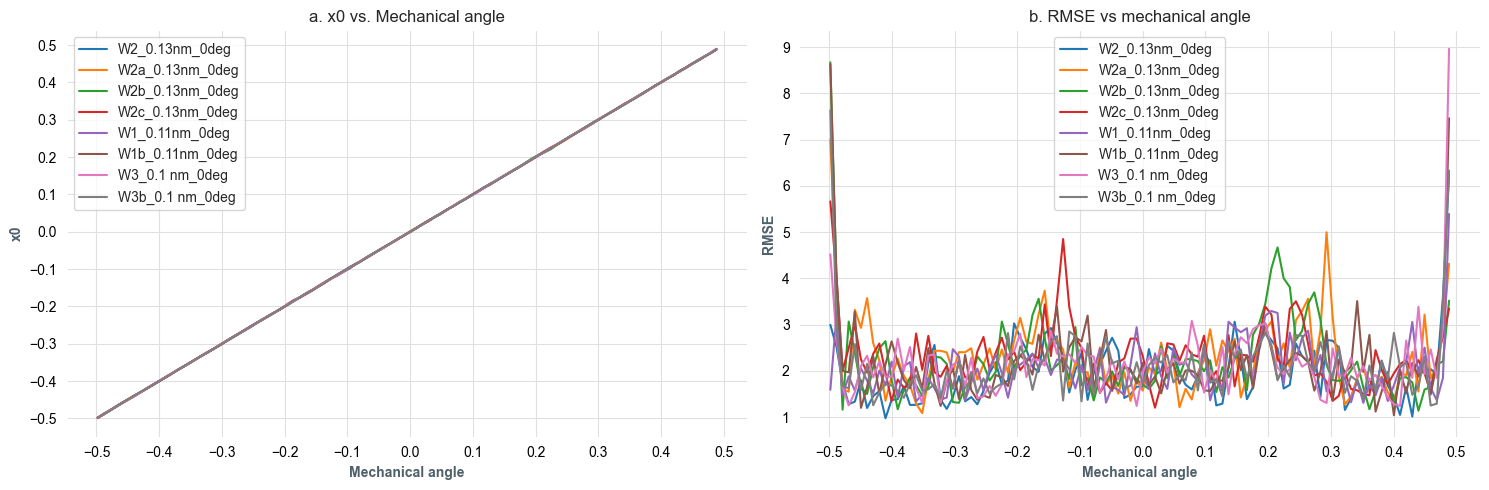

In [14]:
#| label: fig-4-6
#| fig-cap: "Optimized RMSE for 0.1 nm Si wafers"

fig_base, axes_base = plt.subplots(1, 2, figsize=(15, 5), squeeze=False)

for file, row in df_datasets[(df_datasets['baser'] == 'x') & (df_datasets['offaxisvalue'] == 0)].iterrows():
    min_df = row.min_df.copy()
    label = row.label
    amplitudes = min_df['amplitude'].values
    axes_base[0][0].plot(min_df['angle'], min_df['x0'], label=label)

    axes_base[0][1].plot(min_df['angle'], min_df['rmse'], label=label)

    # axes_base[1][0].plot(min_df['x0'], min_df['difference'], label=label)
  
    # axes_base[1][1].plot(min_df['angle'], min_df['amplitude'], label=label)
    

axes_base[0][0].legend()
axes_base[0][0].set_title('a. x0 vs. Mechanical angle')
plot_format_plt('Mechanical angle', 'x0', 0.1, 0.1, axes_base[0, 0])

axes_base[0][1].legend()
axes_base[0][1].set_title('b. RMSE vs mechanical angle')
plot_format_plt('Mechanical angle', 'RMSE', 0.1, 1, axes_base[0, 1])

# axes_base[1][0].legend()
# axes_base[1][0].set_title('b. difference vs mechanical angle (mechanical angle-x0)')
# plot_format_plt('Mechanical angle', 'difference', 0.1, 0.001, axes_base[1, 0])

# # yticks = [0.8, 0.9, 1.0]
# # axes_1st[1][1].set_yticks(yticks)
# axes_1st[1][1].set_ylim([0.0, 2.0])
# axes_1st[1][1].legend()
# axes_1st[1][1].set_title('d. amplitude vs mechanical angle')
# plot_format_plt('Mechanical angle', 'amplitude', 0.1, 1, axes_1st[1, 1])

sns.set_style("white", rc=my_theme)
fig_base.tight_layout()

The final result for RMSE shown in plot b represents the reference RMSE calculated for very smooth wafers (0.1 nm). This error will be used to compare with rougher samples. Notice that the RMSE increases for angles greater than +-0.45 deg, so that RMSE parameter is valid only within this range.

In [15]:
df_datasets.to_pickle('../data/d_datasets_base.pickle')
# df_datasets.to_csv('../data/d_datasets_base.csv')


\newpage